In [13]:
import sys
import json
import time
import csv
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import dateutil.parser
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime
from datetime import date
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, DateFormatter, drange
from numpy import arange

In [14]:
locations = ["austin", "los_angeles", "chicago"]
db = MongoClient().final

In [ ]:
'''
    Read in csv files for each location into mongo.
    Convert date types of string, bool, float and date before read storing
    inside of MongoDB.
'''

for location in locations:
    if (db["crimes_{}".format(location)].count() > 0):
        db["crimes_{}".format(location)].delete_many({})
    with open('crime_data_{}.csv'.format(location), 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL, skipinitialspace=True)
        headers = next(reader)[0:]
        for row in reader:
            mongoRow = {}
            count = 0
            for header in headers:
                value = row[count]
                value = value.replace("  ", " ")
                value = value.strip()
                try:
                    # Try converting a float
                    value = float(value)
                except ValueError:
                    try:
                        # Try converting a date time
                        value = datetime.strptime(value, "%m/%d/%Y %H:%M:%S %p")
                    except ValueError:
                        try:
                            # Try converting a date time
                            value = datetime.strptime(value, "%d-%b-%y")
                        except ValueError:
                            try:
                                # Try converting a date time
                                value = datetime.strptime(value, "%m/%d/%Y")
                            except ValueError:
                                # Try converting to boolean
                                if (value == "N"):
                                    value = False
                                elif (value == "Y"):
                                    value = True
                                else:
                                    # Assume it is a string 
                                    value = value.replace('""', '')
                                    value = value.replace('"', '')
                key = ""
                for word in header.split():
                    word = word.replace("  ", ' ')
                    word = re.sub('[^A-Za-z0-9]+', '_', word)
                    word = word.strip()
                    word = word.upper()
                    key += word + "_"
                key = key.strip('_')
                mongoRow[key] = value
                count = count + 1
            db["crimes_{}".format(location)].insert_one(mongoRow)
    
print("Completed read in csv files into mongo")

In [ ]:
'''
    Combine the Crime Data sets that were read into Mongo 
    into one master data set for crime
'''

masterColl = db["crimes_master"]

masterColl.delete_many({})

start = datetime(2015, 1, 1, 0, 0, 0)
end = datetime(2016, 1, 1, 0, 0, 0)

# Read in Austin Data into master data set

for doc in db["crimes_austin"].find({'GO_REPORT_DATE': {'$lt': end, '$gte': start}}):
    reported_date = doc["GO_REPORT_DATE"] 
    masterColl.insert_one({
            "Reported_Date": reported_date,
            "Month": reported_date.month,
            "Day" : reported_date.day,
            "Year" : reported_date.year,
            "Description": doc["GO_HIGHEST_OFFENSE_DESC"].upper(),
            "Type": doc["HIGHEST_NIBRS_UCR_OFFENSE_DESCRIPTION"].upper(),
            "City": "AUSTIN"
        })
    
# Read in Los Angeles Data into master data set

for doc in db["crimes_los_angeles"].find({'DATE_RPTD': {'$lt': end, '$gte': start}}):
    reported_date = doc["DATE_RPTD"]
    masterColl.insert_one({
            "Reported_Date": reported_date,
            "Month": reported_date.month,
            "Day" : reported_date.day,
            "Year" : reported_date.year,
            "Description": doc["CRMCD_DESC"].upper(),
            "Type": doc["CRMCD_DESC"].upper(),
            "City": "LOS_ANGELES"
        })

# Read in Chicago Data into master data set

for doc in db["crimes_chicago"].find({'DATE_OF_OCCURRENCE': {'$lt': end, '$gte': start}}):
    reported_date = doc["DATE_OF_OCCURRENCE"]
    masterColl.insert_one({
            "Reported_Date": reported_date,
            "Month": reported_date.month,
            "Day" : reported_date.day,
            "Year" : reported_date.year,
            "Description": doc["SECONDARY_DESCRIPTION"].upper(),
            "Type": doc["PRIMARY_DESCRIPTION"].upper(),
            "City": "CHICAGO"
        })
    
print("Completed combining data sets")

In [ ]:
'''
    Read in weather data from csv files for each location into MongoDB
'''

weatherMasterColl = db["weather_master"]
weatherMasterColl.delete_many({})

for location in locations:        
    with open('weather_data_{}.csv'.format(location), 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL, skipinitialspace=True)
        headers = next(reader)[0:]
        for row in reader:
            mongoRow = {}
            count = 0
            for header in headers:
                value = row[count]
                value = value.replace("  ", " ")
                value = value.strip()
                try:
                    # Try converting a float
                    value = float(value)
                except ValueError:
                    try:
                        # Try converting a date time
                        value = datetime.strptime(value, "%Y-%m-%d")
                    except ValueError:
                        # Default the value to 0.0
                        # Do not store strings
                        value = 0.0
                key = ""
                for word in header.split():
                    word = word.replace("  ", ' ')
                    word = re.sub('[^A-Za-z0-9]+', '_', word)
                    word = word.strip()
                    word = word.upper()
                    key += word + "_"
                key = key.strip('_')
                mongoRow[key] = value
                count = count + 1
            mongoRow["CITY"] = location.upper()
            weatherMasterColl.insert_one(mongoRow)
    
print("Completed read in weather data from csv files into mongo")

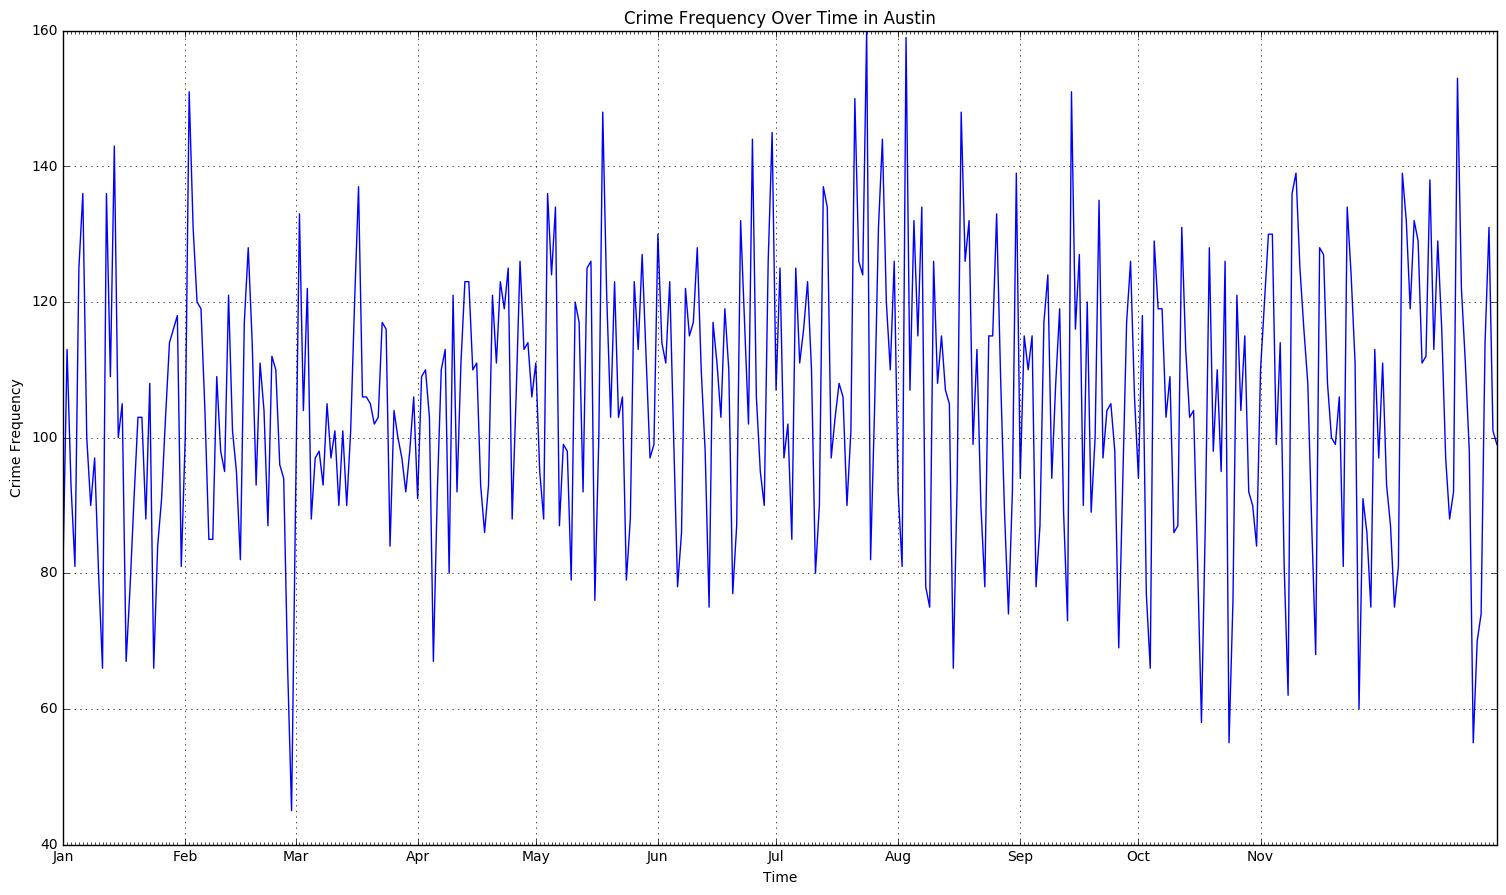

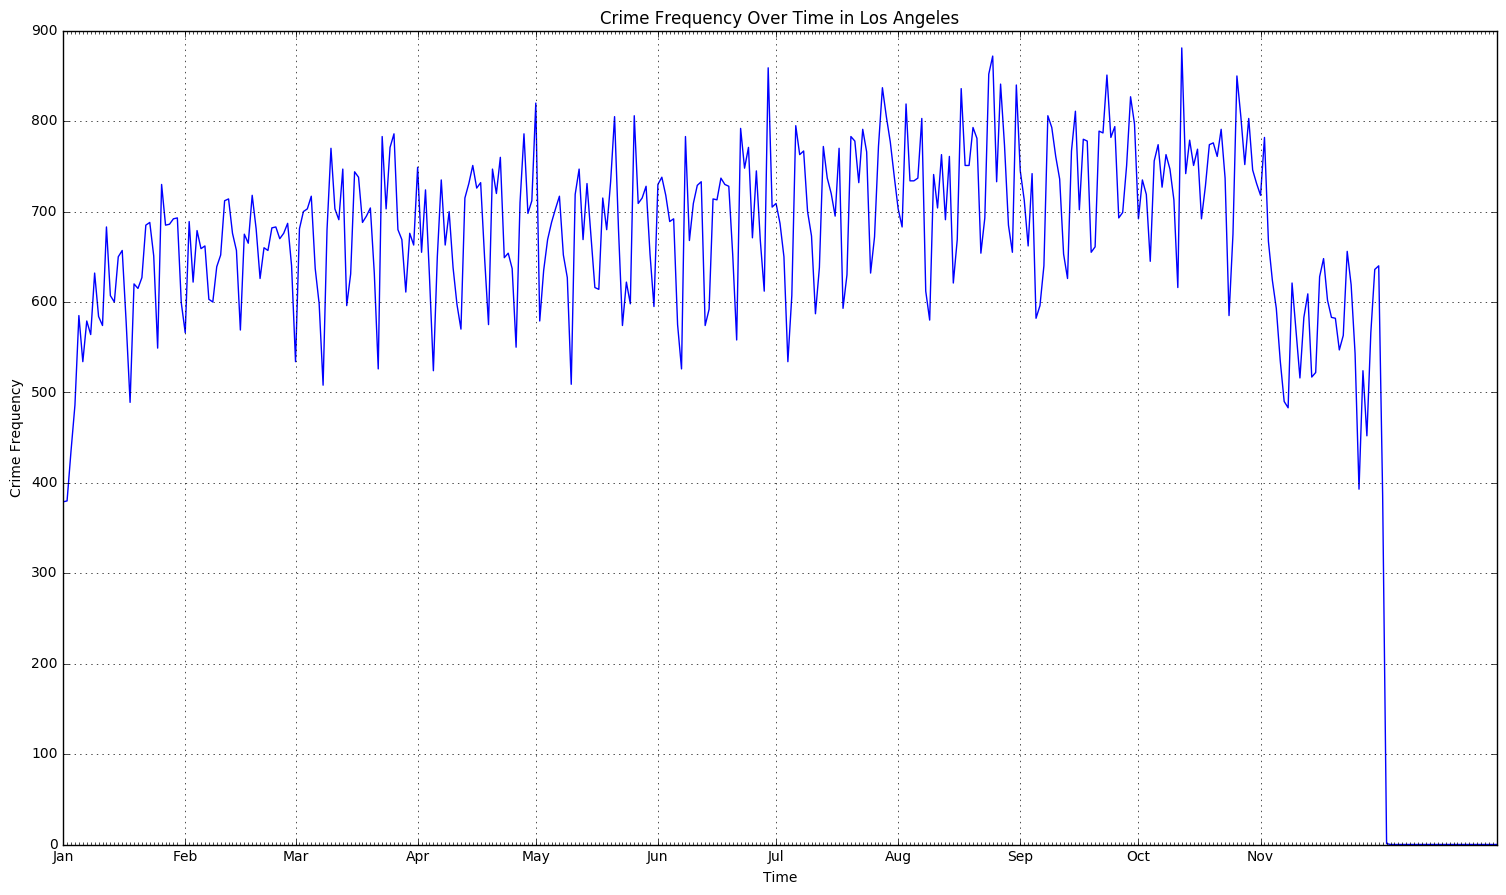

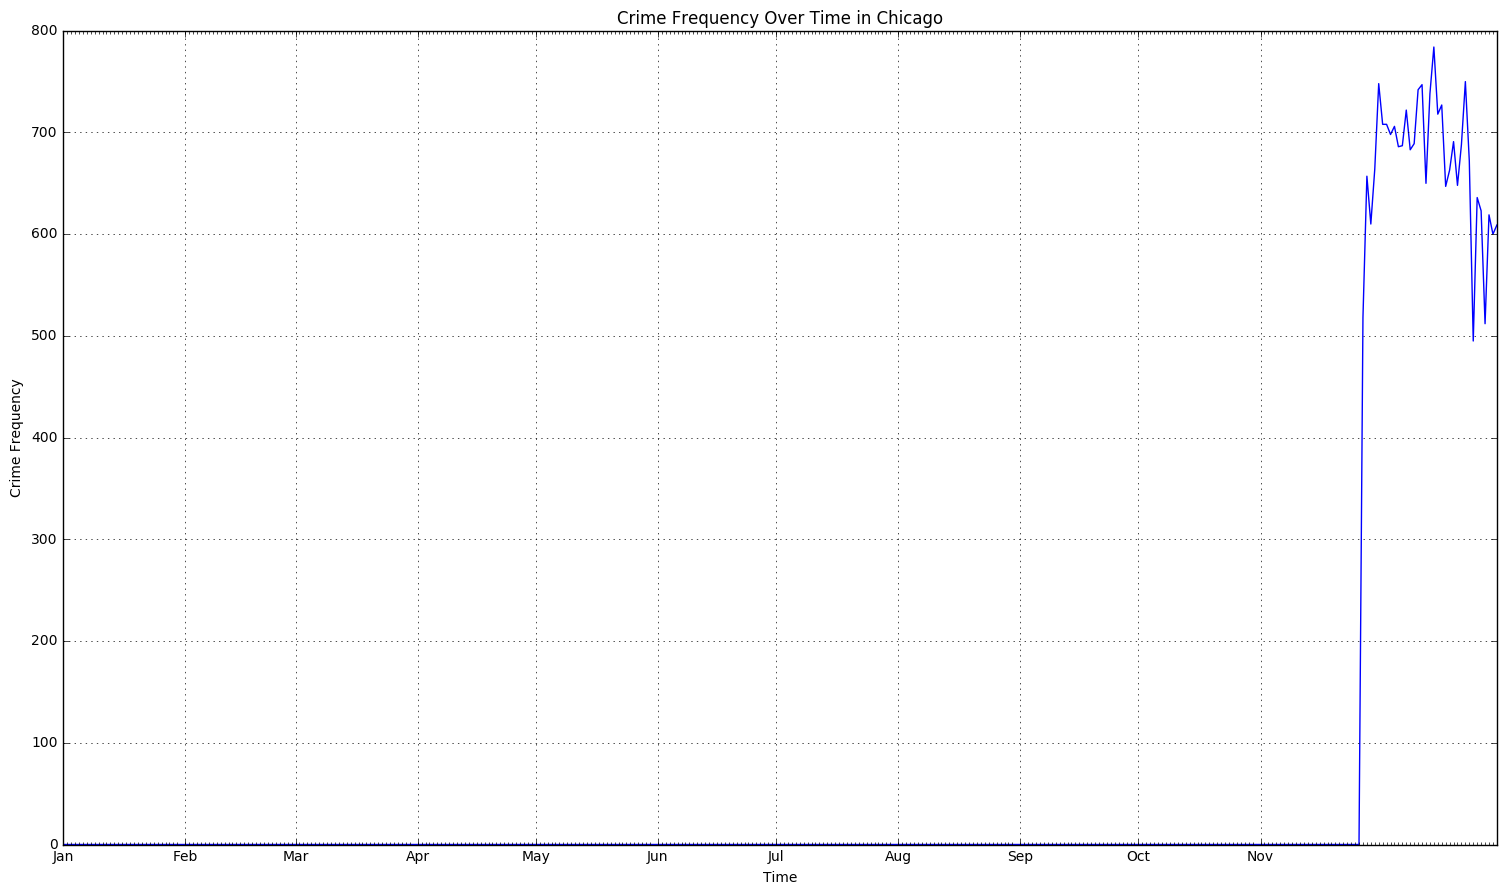

In [17]:
'''
Graph Crime Frequency Over Time for each Location
'''

for location in locations:
    # Create x and y variable arrays for training model
    y_variables = []
    x_variables = []
    for weather in db["weather_master"].find({"CITY": location.upper()}):
        try:
            weather_date = weather["CST"]
        except:
            weather_date = weather["PST"]
        y_variables.append(db["crimes_master"].find({
                    "City": location.upper(), 
                    "Year": weather_date.year, 
                    "Month": weather_date.month, 
                    "Day": weather_date.day}).count())
        x_variables.append(weather_date)
    y_variables = np.array(y_variables)
    x_variables = np.array(x_variables)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot(x_variables, y_variables)
    ax.xaxis.set_major_locator(MonthLocator(arange(0, 12, 1)))
    ax.xaxis.set_minor_locator(DayLocator(arange(0, 31, 1)))
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    
    city_name = ""
    location_strings = location.split("_")
    if (len(location_strings) > 1):
        city_name = "{} {}".format(location_strings[0].capitalize(), location_strings[1].capitalize())
    else:
        city_name = location_strings[0].capitalize()
    
    plt.xlabel('Time')
    plt.ylabel('Crime Frequency')
    plt.title('Crime Frequency Over Time in {}'.format(city_name))
    plt.grid(True)
    plt.savefig("crime_frequency_{}.png".format(location))
    plt.show()

In [ ]:
'''
    Train the data model using Poison Distribution for all locations
'''

for location in locations:
    # Create x and y variable arrays for training model
    y_variables = []
    x_variables = []
    for weather in db["weather_master"].find({"CITY": location.upper()}):
        try:
            weather_date = weather["CST"]
        except:
            weather_date = weather["PST"]
        y_variables.append(db["crimes_master"].find(
                "City": location.upper(), 
                "Year": weather_date.year, 
                "Month": weather_date.month, 
                "Day": weather_date.day}).count())
        x_row = []
        excluded_keys = ["_id","CST","PST","CITY","EVENTS"]
        for key in weather:
            if key not in excluded_keys:
                x_row.append(float(weather[key]))
        x_variables.append(x_row)
    y_variables = np.array(y_variables)
    x_variables = np.array(x_variables)

    # Train the data model using Poisson
    endog = y_variables
    exog = sm.add_constant(x_variables, prepend=False)
    glm_poisson = sm.GLM(endog, exog, sm.families.Poisson())
    result = glm_poisson.fit()
    print(result.summary())

print("Completed creating poisson data models for all locations")

In [ ]:
from AlgoRunner import DataParser
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import numpy as np
import statsmodels.api as sm
import dateutil.parser
import matplotlib.pyplot as plt
import sklearn.linear_model as lm

def plot_model(dates, y_data, y_pred, label_data, label_pred):
    fig, ax = plt.subplots()
    ax.plot(dates, y_data, 'blue', label=label_data)
    if len(y_pred)>0:
        ax.plot(dates, y_pred, 'red', label=label_pred)
    ax.legend(loc="best")
    plt.show()

def plot_model_poisson(result, x_variables, location, dates, test_dates, y_variables, y_exog, t_exog, in_sample_size):
    in_sample_ypred = result.predict()
    print('{} in-sample prediction completed'.format(location))
    plot_model(dates, y_variables, in_sample_ypred, "{} : In Sample Data".format(location), "{} : In sample Poisson prediction".format(location))
    if in_sample_size > 0:
        out_sample_ypred = result.predict(t_exog)
        plot_model(test_dates, y_exog, out_sample_ypred, "{} : Out of Sample Data".format(location), "{} : Out of sample Poisson prediction".format(location))

def fit_model_helper(y_variables, x_variables, model_type = 'Poisson'):
    if model_type == 'Poisson':
        glm_model = sm.GLM(y_variables, x_variables, sm.families.Poisson)
        # for correcting overdispersion
        #glm_poisson = sm.NegativeBinomial(y_variables, x_variables, loglike_method='nb1')
        result = glm_model.fit()
    else:
        logistic_model = lm.LogisticRegression()
        result = logistic_model.fit(x_variables, y_variables)
        print(result)
    return result

def fit_model(location, in_sample_size=-1, models=['poisson','binomial']): #-1 is full
    db = MongoClient().final
    # Create x and y variable arrays for training model
    x_keys = []
    y_variables = []
    x_variables = []
    dates = []
    res = {}

    #for testing
    test_y = []
    test_x = []
    test_dates = []

    all_y = []
    all_dates = []
    counter = 0
    x_keys = []
    for weather in db["weather_master"].find({"CITY": location.upper()}):
        try:
            weather_date = weather["CST"]
        except:
            weather_date = weather["PST"]

        excluded_keys = ["_id","CST","PST","CITY","EVENTS"]
        if counter == 0:
            for key in weather:
                if key not in excluded_keys:
                    x_keys.append(key)
            x_keys.append('intercept')

        x_row = []
        for key in weather:
            if key not in excluded_keys:
                x_row.append(float(weather[key]))

        #constant
        x_row.append(1)

        if counter==0:
            print(len(x_keys))
            print(x_row)
            print(x_keys)

        if (len(x_keys)-len(x_row)) != 0:
            print(len(x_row))
            print(len(x_keys))
            #dont append bad data
            continue

        search_query = {
            'CITY':location.upper(),
            'Day': weather_date.day,
            'Month': weather_date.month,
            'Year': weather_date.year
        }
        #search_query = {'CITY':location.upper(), 'Day': weather_date.day, 'Year': weather_date.year}
        #search_query['Description'] = '/THEFT/'
        y_val = db["crimes_master"].find(search_query).count()
        #if location == 'chicago':
        #  y_val = y_val + int(np.random.poisson(20))

        if in_sample_size > 0 and counter > in_sample_size:
            test_x.append(x_row)
            test_y.append(y_val)
            test_dates.append(weather_date)
        else:
            x_variables.append(x_row)
            y_variables.append(y_val)
            dates.append(weather_date)

        counter+=1
        all_y.append(y_val)
        all_dates.append(weather_date)

    print('Total size of Training data : {}'.format(len(y_variables)))
    y_vars = np.array(y_variables)
    x_vars = np.array(x_variables)
    dates = np.array(dates)
    test_y = np.array(test_y)
    test_x = np.array(test_x)
    test_dates = np.array(test_dates)
    plot_model(all_dates, all_y, [], 'All Data : {}'.format(location), '')

    if 'binomial' in models:
        a = sorted(all_y)
        low_val = a[int(len(a)/3)]
        high_val = a[int(2*len(a)/3)]
        y_variables_bin = []
        for indx in range(len(y_variables)):
            if(y_variables[indx]<=low_val):
                y_variables_bin.append(0)
            else:
                if (y_variables[indx]>high_val):
                    y_variables_bin.append(2)
                else:
                    y_variables_bin.append(1)

        y_test_bin = []
        for indx in range(len(test_y)):
            if(test_y[indx]<=low_val):
                y_test_bin.append(0)
            else:
                if (test_y[indx]>high_val):
                    y_test_bin.append(2)
                else:
                    y_test_bin.append(1)

        print(y_variables_bin)
        result_bin = fit_model_helper(y_variables_bin, x_variables, 'binomial')
        in_sample_ypred = result_bin.predict(x_variables)
        print('{} in-sample Binomial prediction completed'.format(location))
        plot_model(dates, y_variables_bin-in_sample_ypred, [], "{} : In Sample Data Binomial Fit".format(location), "{} : In sample Binomial prediction".format(location))
        total_count = len(y_variables_bin)
        correct_pred = 0
        for val in (y_variables_bin-in_sample_ypred):
            if val == 0:
                correct_pred += 1

        print('{} : Binomial success In-Sample = {} '.format(location, correct_pred*100.0/total_count ))
        if in_sample_size > 0:
            out_sample_ypred = result_bin.predict(test_x)
            plot_model(test_dates, y_test_bin-out_sample_ypred,[], "{} : Out of Sample Data Binomial Test".format(location), "{} : Out of sample Binomial prediction".format(location))
            total_count = len(y_test_bin)
            correct_pred = 0
            for val in (y_test_bin-out_sample_ypred):
                if val == 0:
                    correct_pred += 1
            print('{} : Binomial success Out-of-Sample = {} '.format(location, correct_pred*100.0/total_count ))

        res['binomial_res'] = result_bin

    if 'poisson' in models:
        # Train the data model using Poisson
        Y = pd.DataFrame(y_vars, columns=['Crime Rate'])
        X = pd.DataFrame(x_vars, columns=x_keys)
        y_exog = pd.DataFrame(test_y, columns=['Crime Rate'])
        t_exog = pd.DataFrame(test_x, columns=x_keys)

        print(len(y_variables))
        result = fit_model_helper(Y, X)
        #print(result.summary())
        #print(result.pvalues)

        pvalue_cutoff = 0.05
        pvalues = result.pvalues
        x_keys_new = []
        count = -1
        for key in x_keys:
            count+=1
            if pvalues[key] < pvalue_cutoff:
                x_keys_new.append(x_keys[count])

        result = fit_model_helper(Y, X[x_keys_new])
        print(result.summary())
        plot_model_poisson(result, location, dates, test_dates, y_vars, y_exog, t_exog[x_keys_new], in_sample_size)
        res['result'] = result

    return res

FitModel = True
if FitModel:
    models = ['binomial']
    db = MongoClient().final
    for location in ['los_angeles']:#DataParser.locations:
        print(db["crimes_master"].find({'CITY':location.upper()}).distinct('Type'))
        mod_res = fit_model(location, 244, models) #2/3rd of 365
        if 'poisson' in models:
            result = mod_res['result']
            print(result.summary())
            print(result.params)
            a = 1
    print("Completed creating Poisson data models for all locations")
